In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

def d2np(d):
    
    names = []
    numbers = ()
    dtypes = []
    for item in d:
        names += item 
        if type(d[item]) == float:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == np.float64:
            numbers += (d[item],)
            dtypes += [(item,float)]
        if type(d[item]) == np.ndarray:
            numbers += (d[item],)
            dtypes += [(item,np.float64,d[item].shape)]
    return np.array([numbers],dtype=dtypes)

In [2]:
# [1] D. Ochoa and S. Martinez, 
# “Fast-Frequency Response provided by DFIG-Wind Turbines and its impact on the grid,” 
# IEEE Trans. Power Syst., vol. 8950, no. c, pp. 1–1, 2016.

@numba.jit(nopython=True, cache=True)
def wind_turbine_fit(struct,i,m):
    
    nu_w = struct[i]['nu_w']    # m/s
    omega_t = struct[i]['omega_t'] # rad/s
    beta = struct[i]['beta']       # deg

    C_1 = struct[i]['C_1']
    C_2 = struct[i]['C_2']
    C_3 = struct[i]['C_3']
    C_4 = struct[i]['C_4']
    C_5 = struct[i]['C_5']
    C_6 = struct[i]['C_6']
    
    #Omega_t_n = struct['Omega_t_n'] # 
    Radio = struct[i]['Radio']
    Rho = struct[i]['Rho']  

    lam = omega_t*Radio/nu_w
    inv_lam_i = 1/(lam + 0.08 * beta) - 0.035/(beta**3 + 1)
    c_p = C_1 * (C_2 * inv_lam_i - C_3 * beta - C_4) * np.exp(-C_5*inv_lam_i) + C_6 * lam
    
    p_w = 0.5*Rho*np.pi*Radio**2*nu_w**3*c_p
    
    tau_t = 0.001
    if omega_t>0.0:
        tau_t = p_w/omega_t
    
    struct[i]['p_w'] = p_w
    struct[i]['c_p'] = c_p
    struct[i]['lam'] = lam
    struct[i]['tau_t'] = tau_t

    return 0


@numba.jit(nopython=True, cache=True)
def mppt_fit(struct,i,m):

    omega_t = struct[i]['omega_t'] # rad/s

    C_1 = struct[i]['C_1']
    C_2 = struct[i]['C_2']
    C_3 = struct[i]['C_3']
    C_4 = struct[i]['C_4']
    C_5 = struct[i]['C_5']
    C_6 = struct[i]['C_6']
    lam_opt = struct[i]['lam_opt']
    beta = struct[i]['beta']
    
    #Omega_t_n = struct['Omega_t_n'] # 
    Radio   = struct[i]['Radio']
    Rho = struct[i]['Rho']  

    inv_lam_i = 1/(lam_opt + 0.08 * beta) - 0.035/(beta**3 + 1)
    c_p = C_1 * (C_2 * inv_lam_i - C_3 * beta - C_4) * np.exp(-C_5*inv_lam_i) + C_6 * lam_opt
    
    #lam = omega_t*R/nu_w
    nu_w = omega_t*Radio/lam_opt
    p_ref = 0.5*Rho*np.pi*Radio**2*nu_w**3*c_p

    struct[i]['p_mppt'] = p_ref
    return p_ref


@numba.jit(nopython=True, cache=True)
def wecs_mech_1(struct,i,m):

    omega_t = struct[i]['x'][0,0]  # rad/s
    tau_t   = struct[i]['tau_t']
    tau_r   = struct[i]['tau_r']
       
    J_t  = struct[i]['J_t']
    N_tr = struct[i]['N_tr']
    Dt   = struct[i]['Dt']

    domega_t = 1.0/J_t*(tau_t - N_tr*tau_r)

    omega_r = N_tr*omega_t 
    
    struct[i]['f'][:,0] = domega_t

    struct[i]['omega_r'] = omega_r
    struct[i]['omega_t'] = omega_t

    return omega_t


In [3]:
@numba.jit(nopython=True, cache=True)
def pitch(struct,i,m):
    Dt  = struct[i]['Dt']
    beta_ref  = struct[i]['beta_ref']
    beta      = struct[i]['beta']
    beta_rate = struct[i]['beta_rate']

    if beta<beta_ref:
        beta += beta_rate * Dt
        
    if beta>beta_ref:
        beta -= beta_rate * Dt
        
    struct[i]['beta'] = beta

    return beta

In [4]:
Radio = 50.0
lam_opt = 8.0
Nu_w_n = 10.0
Omega_t_n = Nu_w_n*lam_opt/Radio*0.8
Omega_t_max = Omega_t_n*1.25
Omega_t_min = Omega_t_n*0.75
beta = 0.0
Rho = 1.225
C_1 = 0.5176
C_2 = 116.0
C_3 = 0.4
C_4 = 5.0
C_5 = 21.0
C_6 = 0.0068
inv_lam_i = 1/(lam_opt + 0.08 * beta) - 0.035/(beta**3 + 1)
c_p = C_1 * (C_2 * inv_lam_i - C_3 * beta - C_4) * np.exp(-C_5*inv_lam_i) + C_6 * lam_opt
P_t_n = 0.5*Rho*np.pi*Radio**2*Nu_w_n**3*c_p
P_t_n/1e6

2.3080100601373608

In [5]:
N = 100

#nu_w =np.linspace(0.1,15,N)
H = 4.5

# H = 0.5*J*Omega_t_n**2/S_b
S_b = 2.0e6
Omega_t_n = 1.5
J_t = 2*H*S_b/Omega_t_n**2


d = dict(Radio=Radio,
         Rho = 1.225,
         C_1 = 0.5176,
         C_2 = 116.0,
         C_3 = 0.4,
         C_4 = 5.0,
         C_5 = 21.0,
         C_6 = 0.0068,
         P_t_n = P_t_n,
         nu_w = Nu_w_n,
         omega_t = Omega_t_n,
         beta = 0.0,
         Omega_t_n = Omega_t_n,
         Omega_t_min = Omega_t_min,
         Omega_t_max = Omega_t_max,
         Nu_w_n = Nu_w_n,
         p_w = 0.0,
         c_p = 0.0,
         lam = 0.0,
         lam_opt = 8.0,
         J_t = J_t,     
         N_tr = 20.0,  
         x = np.ones((1,1)),
         f = np.zeros((1,1)),
         omega_r = 1.0,
         tau_t = 10.0,
         tau_r = 0.0,
         Dt = 10.0e-3,
         p_mppt = 1.0,
         beta_ref = 0.0,
         beta_rate = 0.1,
        )
 
struct = d2np(d)
i=0
m=2
wind_turbine_fit(struct,i,m)
mppt_fit(struct,i,m)
wecs_mech_1(struct,i,m)
pitch(struct,i,m)

0.0

In [6]:
%timeit pitch(struct,i,m)

The slowest run took 15.25 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 579 ns per loop


<IPython.core.display.Javascript object>


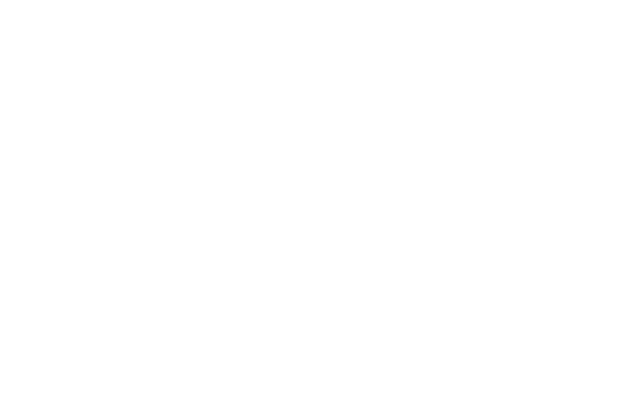

TypeError: not enough arguments: expected 3, got 2

In [7]:
struct = d2np(d)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
betas = np.linspace(0.0,24,5)
omegas = np.linspace(0.1,3.5,100)
for beta in betas:
    C_p = []
    Lam = []
    for omega in omegas:
        struct['beta'] = beta
        struct['omega_t'] = omega
        wind_turbine_fit(struct,0)
        C_p += [float(struct['c_p'])]
        Lam += [float(struct['lam'])]
    axes.plot(np.array(Lam),np.array(C_p))
    axes.set_ylabel('$\sf C_p ( \lambda,\\beta )$')
    axes.set_xlabel('$\sf \lambda$')
    axes.set_ylim([0,0.5])
    axes.set_xlim([0,22])
    struct[0]['c_p']

fig.savefig('lam_cp.svg', bbox_inches='tight')


In [ ]:
struct = d2np(d)
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
struct['beta'] = 0.0
nu_ws = np.linspace(5,10,5)
omegas = np.linspace(0.1,3.5,100)
for nu_w in nu_ws:
    P_w = []
    Omega = []
    for omega in omegas:
        struct['nu_w'] = nu_w
        struct['omega_t'] = omega
        wind_turbine_fit(struct,0)
        P_w += [float(struct['p_w'])]
        Omega += [float(struct['omega_t'])]
    axes.plot(Omega,np.array(P_w)/1e6)

omega = 1
Nu = np.linspace(2,12,20)
omegas_opt = []
p_ref_opt = []
for nu in Nu:
    struct['nu_w'] = nu
    for it in range(500):
        struct['omega_t'] = omega
        mppt_fit(struct,0)  
        wind_turbine_fit(struct,0)  
        p_ref = float(struct['p_mppt'])
        p_t = float(struct['p_w'])
        omega += 0.0000001*(-p_ref + p_t)/omega
        if abs(-p_ref + p_t)<0.01:
            break
    
    omegas_opt += [float(struct['omega_t'])]
    p_ref_opt += [float(struct['p_w'])] 
        
axes.set_ylabel('$\sf P_t$')
axes.set_xlabel('$\sf \omega_t$')
axes.set_ylim([0,2.5])
axes.set_xlim([0,3.0])

fig.savefig('w_p_t.svg', bbox_inches='tight')
axes.plot(np.array(omegas_opt),np.array(p_ref_opt)/1e6, 'r')   

fig.savefig('w_p_t_mppt.svg', bbox_inches='tight')


## without MPPT

In [ ]:
struct = d2np(d)
struct['nu_w'] = 5.0
for it in range(10000):
    wecs_mech_1(struct,0)
    struct[0]['x'] += 100.0e-3*struct[0]['f'][0,0]
print(struct['omega_t'])
print(struct['p_w']/1e6)

## with MPPT

In [ ]:
struct['omega_t'] = 1.0
struct['omega_r'] = 1.0*20
struct['nu_w'] = 8.5
t = 0.0
Omega_t = []
P_w = []
T = []
Dt = 100.0e-3
for it in range(500):
    if t>10.0:
        struct['nu_w'] = 6.0
        
    wecs_mech_1(struct,0)
    mppt_fit(struct,0)  
    struct['tau_t'] = struct['p_w']/struct['omega_t']
    struct['tau_r'] = struct['p_mppt']/struct['omega_r']
    wind_turbine_fit(struct,0)  
    struct[0]['x'] += Dt*struct[0]['f'][0,0]
    struct['omega_t'] = float(struct[0]['x'])
    Omega_t += [float(struct['omega_t'])]
    P_w += [float(struct['p_w'])]
    T += [t]
    t+= Dt
P_w = np.array(P_w)
print(struct['omega_t'])
print(struct['p_w']/1e6)

In [ ]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)

axes.plot(T,Omega_t)


In [ ]:
plt.tight_layout()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)

axes.plot(T,P_w/1e6)

In [ ]:
struct['beta_ref'] = 0.0
struct['beta'] = 0.0
for it in range(1000):
    t = it*struct['Dt']
    if t>0.1:
        struct['beta_ref'] = 5.0
        
    pitch(struct,0)
   # print(t, struct['beta'])

In [ ]:
import numpy as np 
import sympy as sym
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rc('animation', html='html5')
%matplotlib notebook 

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
fig.set_animated(True)
omegas = np.linspace(0.1,3.5,300)
p_w_line = axes.plot([], '-', ms=8) 
axes.plot([struct[0]['Omega_t_max']]*2,[-10,10], '--', ms=2, color='k') 
axes.plot([struct[0]['Omega_t_min']]*2,[-10,10], '--', ms=2, color='k') 
axes.plot([-10,10], [struct[0]['P_t_n']/1.0e6]*2, '--', ms=2, color='k') 

p_mppt_line = axes.plot(np.array(omegas_opt),np.array(p_ref_opt)/1e6) 
p_mppt_point = axes.plot(0.0,0.0, 'or', ms=12)
axes.set_xlabel('$\sf \omega_t$')
axes.set_ylabel('$\sf P_t$')
axes.grid(True)

axes.set_ylim([0,2.5])
axes.set_xlim([0,3.0])
def update(beta,nu_w,court):
    P_w = []
    P_mppt =[]
    Omega = []
    
    struct['nu_w'] = nu_w   
    for omega in omegas:
        struct['beta'] = beta 
        struct['omega_t'] = omega
        wind_turbine_fit(struct,0)
        P_w += [float(struct['p_w'])]
        Omega += [float(struct['omega_t'])]
        struct[0]['beta'] = 0.0 
        struct[0]['omega_t'] = omega*(court)
        mppt_fit(struct,0)
        P_mppt +=[float(struct['p_mppt'])]
    Omega = np.array(Omega)
    P_w = np.array(P_w)
    P_mppt = np.array(P_mppt)
    sh = 20
    idx = np.argmin(np.abs(P_w[sh:]-P_mppt[sh:]))
    #axes.plot(Omega,np.array(P_w)/1e6)
    p_w_line[0].set_xdata(np.array(Omega))
    p_w_line[0].set_ydata(np.array(P_w)/1.0e6)
    p_mppt_line[0].set_xdata(np.array(Omega))
    p_mppt_line[0].set_ydata(np.array(P_mppt)/1.0e6)
    print('Pt = {:2.2f} MW  speed = {:2.2f} p.u.'.format(P_w[idx+sh]/1.0e6, Omega[idx+sh]/struct[0]['Omega_t_n']))
    p_mppt_point[0].set_xdata(Omega[idx+sh])
    p_mppt_point[0].set_ydata(P_w[idx+sh]/1.0e6)
    
sld_beta  = widgets.FloatSlider(min=0,max=20,step=0.1,value=0.0, width=1000)
sld_nu_w  = widgets.FloatSlider(min=0.1,max=20,step=0.1,value=struct['Nu_w_n'], width=1000)
sld_court = widgets.FloatSlider(min=0.1,max=1,step=0.02,value=1, width=1000)

interaction_avr = interactive(update,
                          beta=sld_beta,
                          nu_w=sld_nu_w,
                          court=sld_court,
                          continuous_update=True, width=1000) 



In [ ]:
display(interaction_avr)

In [ ]:
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import threading
import time

exitFlag = 0

class myThread (threading.Thread):
    def __init__(self, threadID, name, counter):
        threading.Thread.__init__(self)
        self.threadID = threadID
        self.name = name
        self.counter = counter
    def run(self):
        print ("Starting " + self.name)
        print_time(self.name, self.counter, 50)
        print("Exiting " + self.name)

def print_time(threadName, counter, delay):
    while 0:
        if exitFlag:
            threadName.exit()
        time.sleep(delay)
        print("%s: %s" % (threadName, time.ctime(time.time())))
        counter -= 1

# Create new threads
thread1 = myThread(1, "Thread-1", 1)
thread2 = myThread(2, "Thread-2", 2)

# Start new Threads
thread1.start()
thread2.start()

print("Exiting Main Thread")

In [ ]:
x = np.array([1])
def update(value_1):
    print(value_1)
    x[0] = value_1
    
sld_1  = widgets.FloatSlider(min=0,max=20,step=0.1,value=0.0, width=1000)
interaction_1 = interactive(update,
                              value_1 = sld_1,
                              continuous_update=True, width=1000) 

In [ ]:
display(interaction_1)

<IPython.core.display.Javascript object>


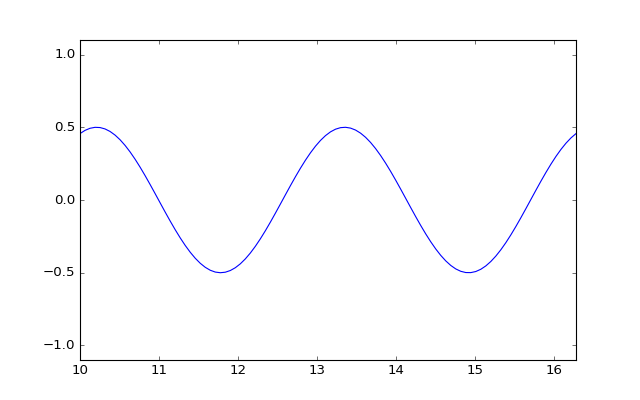

In [3]:
import numpy as np 
import sympy as sym
from ipywidgets import interact, interactive, widgets
from IPython.display import display
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rc('animation', html='html5')
%matplotlib notebook 

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5), sharex = True)
fig.set_animated(True)
line_1 = axes.plot([], '-', ms=8) 
axes.set_xlim([0.0,2*np.pi])
axes.set_ylim([-1.1,1.1])

class anima(object):
    
    def __init__(self):
        self.A = 1.0
    
def update(t):
    fobj = open('dato','r')
    A = float(fobj.read())
    fobj.close()
    x = np.linspace(0,2*np.pi,100)+ t
    line_1[0].set_xdata(x)
    line_1[0].set_ydata(A*np.sin(2*x))
    axes.set_xlim([0.0+t,2*np.pi+t]) 

        
def uparam(A):
    fobj = open('dato','w')
    fobj.write(str(A))
    fobj.close()



anima1 = anima()

sld_1  = widgets.FloatSlider(min=0,max=20,step=0.1,value=0.0, width=1000)
interaction_1 = interactive(uparam,
                              A = sld_1,
                              continuous_update=True, width=1000)
    

In [5]:
 
display(interaction_1)

import time 
for t in np.linspace(0.0,10.0,100):
    update(t)
    time.sleep(0.1)
    fig.canvas.draw()

In [ ]:
help(fig.draw)

In [14]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim

def plot_cont(fun, xmax):
    y = []
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)

    def update(i):
        yi = fun()
        y.append(yi)
        x = range(len(y))
        ax.clear()
        ax.plot(x, y)
        print( i, ': ', yi)

    a = anim.FuncAnimation(fig, update, frames=xmax, repeat=False)
    plt.show()